--- 1. Initial Data Inspection ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          199 non-null    int64  
 1   normalized-losses  160 non-null    float64
 2   make               199 non-null    object 
 3   fuel-type          199 non-null    object 
 4   aspiration         199 non-null    object 
 5   num-of-doors       197 non-null    object 
 6   body-style         199 non-null    object 
 7   drive-wheels       199 non-null    object 
 8   engine-location    199 non-null    object 
 9   wheel-base         199 non-null    float64
 10  length             199 non-null    float64
 11  width              199 non-null    float64
 12  height             199 non-null    float64
 13  curb-weight        199 non-null    int64  
 14  engine-type        199 non-null    object 
 15  num-of-cylinders   199 non-null    obje

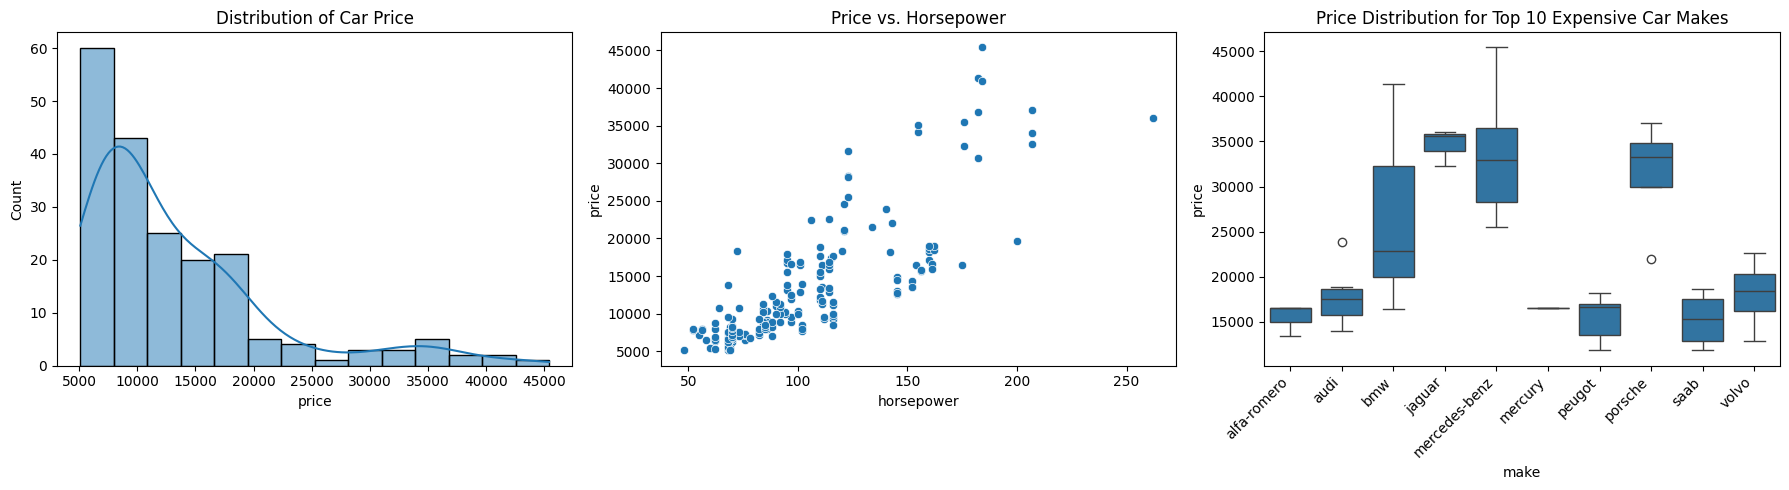


--- EDA Complete. Key insights: Price is skewed, 'horsepower' and 'engine-size' highly correlate with 'price', and categorical features need encoding. ---


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the file path (assuming the CSV is in the same directory)
file_path = 'carprice.csv'

# Load the dataset, treating '?' as a missing value (NaN)
df = pd.read_csv(file_path, na_values='?')

print("--- 1. Initial Data Inspection ---")
print(df.info())

# Convert object types that should be numeric to numeric, forcing errors to NaN
# 'price' and 'normalized-losses' are initially object/string due to '?'
numeric_cols_to_convert = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
for col in numeric_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where the target variable 'price' is missing
df_clean = df.dropna(subset=['price']).copy()
print(f"\nData Shape after dropping {df.shape[0] - df_clean.shape[0]} rows with missing 'price': {df_clean.shape}")

# --- EDA Analyses ---

print("\n--- 2. Summary Statistics for Key Numerical Features ---")
print(df_clean[['price', 'horsepower', 'city-mpg', 'engine-size', 'curb-weight']].describe().T)

print("\n--- 3. Missing Value Analysis (Features needing imputation/removal in Preprocessing) ---")
missing_values = df_clean.isnull().sum()[df_clean.isnull().sum() > 0].sort_values(ascending=False)
print(missing_values)

print("\n--- 4. Feature Distribution (Data Types and Unique Value Counts) ---")
print("Data Types after cleaning:")
print(df_clean.dtypes)
print("\nUnique Values Count for Categorical Features (Top 5):")
for col in df_clean.select_dtypes(include='object').columns:
    print(f"'{col}': {df_clean[col].nunique()} unique values. Top 5: {df_clean[col].value_counts().head().index.tolist()}")

# --- 5. Correlation Analysis and Visualizations (Output plots for Streamlit) ---

# Correlation Matrix (Pairwise feature relationships)
numerical_df = df_clean.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()
price_corr = correlation_matrix['price'].sort_values(ascending=False)

print("\n--- 6. Correlation Analysis with Target Variable (Price) ---")
print(price_corr.head(10)) # Top 10 positive and negative correlations

# Visualize key relationships
plt.figure(figsize=(18, 5))

# a) Distribution of the Target Variable (Price)
plt.subplot(1, 3, 1)
sns.histplot(df_clean['price'], kde=True)
plt.title('Distribution of Car Price')

# b) Price vs Horsepower (Strongest positive relationship)
plt.subplot(1, 3, 2)
sns.scatterplot(x='horsepower', y='price', data=df_clean)
plt.title('Price vs. Horsepower')

# c) Grouped Aggregations: Make vs Price (Shows outliers and trend)
plt.subplot(1, 3, 3)
# Group by 'make' and sort to see the highest/lowest average prices
avg_price_by_make = df_clean.groupby('make')['price'].mean().sort_values(ascending=False).index[:10]
sns.boxplot(x='make', y='price', data=df_clean[df_clean['make'].isin(avg_price_by_make)])
plt.title('Price Distribution for Top 10 Expensive Car Makes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() # 
print("\n--- EDA Complete. Key insights: Price is skewed, 'horsepower' and 'engine-size' highly correlate with 'price', and categorical features need encoding. ---")

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

# --- 1. Data Loading and Initial Cleaning ---
file_path = 'carprice.csv'
df = pd.read_csv(file_path, na_values='?')

# Convert potential numeric columns that were read as object/string due to '?'
numeric_cols_to_convert = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
for col in numeric_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where the target variable 'price' is missing
df_clean = df.dropna(subset=['price']).copy()

# --- 2. Handle Textual Numerical Columns (Mapping to Digits) ---
# Fix 'num-of-cylinders' and 'num-of-doors'
word_to_num = {
    'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'eight': 8, 'twelve': 12
}
df_clean['num-of-cylinders'] = df_clean['num-of-cylinders'].map(word_to_num)
df_clean['num-of-doors'] = df_clean['num-of-doors'].map(word_to_num)
print("Converted 'num-of-cylinders' and 'num-of-doors' to numeric type.")

# --- 3. Define Feature and Target Variables ---
# Drop 'symboling' (risk rating) as it is less of a physical feature
X = df_clean.drop(['price', 'symboling'], axis=1)
y = df_clean['price']

# --- 4. Identify Feature Types and Transformations ---
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
print(f"Numerical Features to be Scaled: {numerical_features}")
print(f"Categorical Features to be Encoded: {categorical_features}")

# --- 5. Build the Preprocessing Pipeline using ColumnTransformer ---

# Numerical Pipeline: Impute missing values with the mean, then apply Standard Scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Handle missing values
    ('scaler', StandardScaler())                 # Normalize or scale numerical features
])

# Categorical Pipeline: Impute missing values with the most frequent value, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # Encode categorical variables
])

# Create the preprocessor object (This is the final transformation)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (none in this case)
)

# --- 6. Split Data ---
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrain set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

# --- 7. Fit and Transform Data ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Shape of processed training data:", X_train_processed.shape)

# --- 8. Save Preprocessor and Split Data ---
# The preprocessor object must be saved for runtime predictions in Streamlit
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Saving processed data and targets for the next step (model training)
np.savez('processed_data.npz', X_train=X_train_processed, X_test=X_test_processed, y_train=y_train.values, y_test=y_test.values)

print("\n--- Data Preprocessing Complete ---")
print("Saved preprocessor to 'preprocessor.pkl' and processed data to 'processed_data.npz'.")

Converted 'num-of-cylinders' and 'num-of-doors' to numeric type.
Numerical Features to be Scaled: ['normalized-losses', 'num-of-doors', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'num-of-cylinders', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']
Categorical Features to be Encoded: ['make', 'fuel-type', 'aspiration', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'fuel-system']

Train set size: (156, 24) (156,)
Test set size: (39, 24) (39,)
Shape of processed training data: (156, 62)

--- Data Preprocessing Complete ---
Saved preprocessor to 'preprocessor.pkl' and processed data to 'processed_data.npz'.


In [5]:
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# --- 1. Load Processed Data ---
data = np.load('processed_data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

print("--- 1. Data Loading and Shape Check ---")
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

# --- 2. Select and Train the Machine Learning Model (Regression) ---
# RandomForestRegressor is selected for its robustness and good performance.

print("\n--- 2. Training Random Forest Regressor Model ---")
# Initialize the model
model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=12)

# Train the model
model.fit(X_train, y_train)
print("Model training complete.")

# --- 3. Model Evaluation ---

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Evaluation Metrics
# 1. Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(y_test, y_pred))
# 2. R-squared (R2) Score
r2 = r2_score(y_test, y_pred)

print("\n--- 3. Model Performance Evaluation (on Test Set) ---")
print(f"Model Used: RandomForestRegressor (Regression Model)")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R-squared (R2) Score: {r2:.4f}")

# --- 4. Save the Trained Model for Streamlit Runtime Prediction ---
# This model file will be loaded by the Streamlit application.
with open('car_price_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("\n--- Machine Learning Model Complete ---")
print("Trained model saved as: car_price_model.pkl")
print("You now have all the necessary files to build your Streamlit app (Step 5).")

--- 1. Data Loading and Shape Check ---
Training features shape: (156, 62)
Testing features shape: (39, 62)

--- 2. Training Random Forest Regressor Model ---
Model training complete.

--- 3. Model Performance Evaluation (on Test Set) ---
Model Used: RandomForestRegressor (Regression Model)
Root Mean Squared Error (RMSE): $3,531.87
R-squared (R2) Score: 0.8971

--- Machine Learning Model Complete ---
Trained model saved as: car_price_model.pkl
You now have all the necessary files to build your Streamlit app (Step 5).
